# Rating distributions
Plot distributions of categorical emotion, valence, and arousal ratings.

In [1]:
import os.path as op
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

Gather all categorical emotion ratings.

In [2]:
files = sorted(glob('../data/ratings/*expressive*.tsv'))
counts_train, counts_test = [], []
for f in files:
    sub = op.basename(f).split('_')[0]
    df = pd.read_csv(f, sep='\t', index_col=0)
    df = df.query("rating_type == 'emotion' & rating != 'Geen van allen'")
    df_train = df.query("data_split == 'train'")
    counts_train.append(df_train['rating'].value_counts().to_frame().assign(sub=sub))

    df_test = df.query("data_split == 'test' or data_split == 'test_extra'")
    counts_test.append(df_test['rating'].value_counts().to_frame().assign(sub=sub))

counts_train = pd.concat(counts_train, axis=0)
counts_train['split'] = 'train'
counts_test = pd.concat(counts_test, axis=0)
counts_test['split'] = 'test'
counts = pd.concat((counts_train, counts_test), axis=0)
counts = counts.reset_index().rename({'index': 'emotion'}, axis=1).set_index('sub')
counts = counts.replace(
    {'Boos': 'Anger', 'Blij': 'Happiness', 'Verrassing': 'Suprise',
     'Walging': 'Disgust', 'Bang': 'Fear', 'Verdrietig': 'Sadness'}
)
counts = counts.sort_values('emotion')
for split in ['train', 'test']:
    idx = counts['split'] == split
    counts.loc[idx, 'total'] = counts.loc[idx, :].groupby('sub').sum().loc[counts.loc[idx, :].index, 'rating']

counts.loc[:, 'rating_prop'] = counts.loc[:, 'rating'] / counts.loc[:, 'total']

And valence/arousal ratings.

In [89]:
dfs_c, dfs_e = [], []
for f in files:
    sub = op.basename(f).split('_')[0]
    df = pd.read_csv(f, sep='\t', index_col=0).query("rating_type != 'emotion'")
    df = df.replace({'test_extra': 'test'})
    #df = df.loc[~df['rating'].isna(), :]
    df['rating'] = df['rating'].astype(float)
    #for split in ['train', 'test']:
    #    idx = df['data_split'] == split
    #    ratings = df.loc[idx, 'rating'].to_numpy()
    #    df.loc[idx, 'rating'] = (ratings - ratings.mean()) / ratings.std()
    dfs_c.append(df.assign(sub=sub))
    
    df = pd.read_csv(f, sep='\t', index_col=0).query("rating_type == 'emotion'")
    df = df.replace({'test_extra': 'test'}).replace(
        {'Boos': 'Anger', 'Blij': 'Happiness', 'Verrassing': 'Suprise',
         'Walging': 'Disgust', 'Bang': 'Fear', 'Verdrietig': 'Sadness'}
    )
    #df = df.query("rating != 'Geen van allen'")
    dfs_e.append(df.assign(sub=sub))
    
emo_df = pd.concat(dfs_e, axis=0)
circ_df = pd.concat(dfs_c, axis=0)

In [90]:
ci = circ_df.index.intersection(emo_df.index)

In [98]:
import numpy as np
for sub in range(1, 14):
    arr = np.c_[
        circ_df.query(f"rating_type == 'valence' & sub == 'sub-{str(sub).zfill(2)}'").loc[ci, 'rating'].sort_index(),
        circ_df.query(f"rating_type == 'arousal' & sub == 'sub-{str(sub).zfill(2)}'").loc[ci, 'rating'].sort_index(),
        pd.get_dummies(emo_df.query(f"sub == 'sub-{str(sub).zfill(2)}'").loc[ci, 'rating']).sort_index()
    ]
    arr = arr[~np.isnan(arr.sum(axis=1)), :]
    from scipy.stats import pearsonr
    print(pearsonr(arr[:, 0], arr[:, 6]))

(0.549172991005319, 2.104057634189211e-105)
(0.5891955498762447, 6.171464216825191e-125)
(0.2947896815457737, 4.909790567906333e-28)
(0.5093123493528975, 1.469039854140346e-88)
(0.42826139065745855, 2.327515164611392e-60)
(0.5285388847284054, 1.9346461044479715e-96)
(0.31372428292098153, 1.0185644925461337e-31)
(0.5119439729492054, 1.312241976875583e-89)
(0.2945914067357023, 5.348086968176031e-28)
(0.23619259499913686, 2.712454502738338e-18)
(0.5360539036620043, 1.960198840493383e-65)
(0.22555577028963636, 8.845687917987646e-17)
(0.5370633522934483, 4.2383408591557235e-100)


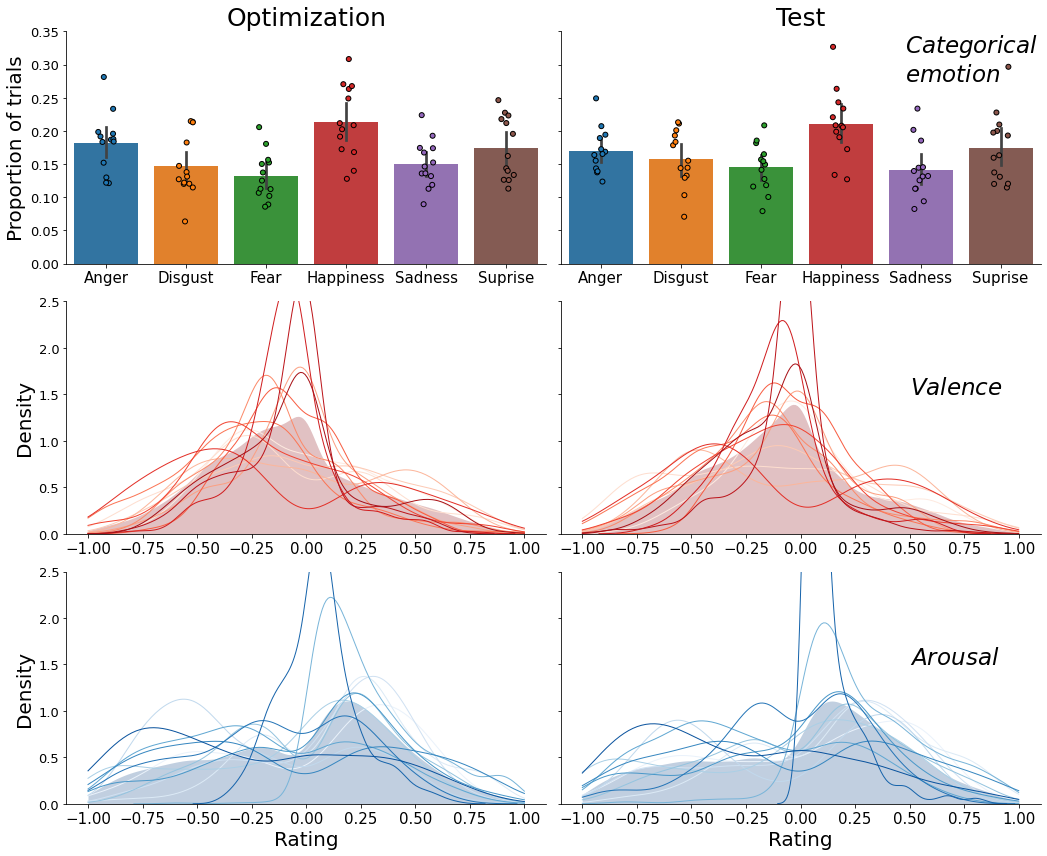

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False, sharey=False, figsize=(15, 12))
for ii, split in enumerate(['train', 'test']):
    axes[0, ii] = sns.barplot(data=counts.query("split == @split"), x='emotion', y='rating_prop', ax=axes[0, ii])
    axes[0, ii] = sns.stripplot(data=counts.query("split == @split"), x='emotion', y='rating_prop', ax=axes[0, ii],
                            linewidth=1, edgecolor='k')
    split_name = 'optimization' if split == 'train' else split
    if ii == 0:
        axes[0, ii].set_ylabel("Proportion of trials", fontsize=20)
    else:
        axes[0, ii].set_ylabel('')
        axes[0, ii].text(3.8, 0.275, r'$\it{Categorical}$' '\n' '$\it{emotion}$', fontsize=23)
        axes[0, ii].get_yaxis().set_ticklabels([])
        
    axes[0, ii].set_xlabel('')
    axes[0, ii].set_ylim(0, 0.35)
    axes[0, ii].set_title(split_name.capitalize(), fontsize=25)
    axes[0, ii].tick_params(axis='y', which='major', labelsize=13)
    axes[0, ii].tick_params(axis='x', which='major', labelsize=15)

    for i, target in enumerate(['valence', 'arousal']):
        dat = circ_df.query("data_split == @split & rating_type == @target")

        if i == 1:
            cmap = sns.color_palette("Blues", as_cmap=False, n_colors=14)
        else:
            cmap = sns.color_palette("Reds", as_cmap=False, n_colors=14)

        axes[i+1, ii] = sns.kdeplot(dat['rating'], ax=axes[i+1, ii], fill=True,
                                    color=cmap[-1], clip=[-1, 1], linewidth=0)
        for iii, sub in enumerate(circ_df['sub'].unique()):
            axes[i+1, ii] = sns.kdeplot(dat.query("sub == @sub")['rating'], ax=axes[i+1, ii], clip=[-1, 1],
                                        color=cmap[iii], lw=1, alpha=0.3)
            
        axes[i+1, ii].set_ylim(0, 2.5)
        axes[i+1, ii].tick_params(axis='y', which='major', labelsize=13)
        axes[i+1, ii].tick_params(axis='x', which='major', labelsize=15)

        if ii == 1:
            axes[i+1, ii].get_yaxis().set_ticklabels([])
            axes[i+1, ii].set_ylabel('')
            if i == 0:
                axes[i+1, ii].text(0.5, 1.5, r'$\it{Valence}$', fontsize=23)
            else:
                axes[i+1, ii].text(0.5, 1.5, r'$\it{Arousal}$', fontsize=23)
        else:
            axes[i+1, ii].set_ylabel("Density", fontsize=20)
            
        if i == 0:
            axes[i+1, ii].set_xlabel('')
        else:
            axes[i+1, ii].set_xlabel('Rating', fontsize=20)
            

sns.despine()
fig.tight_layout()
fig.savefig('../figures/rating_distributions.png', dpi=200)

In [6]:
counts

,emotion,rating,split,total,rating_prop
sub,,,,,
sub-11,Anger,36,test,291.0,0.123711
sub-12,Anger,91,train,487.0,0.186858
sub-06,Anger,182,train,647.0,0.281298
sub-09,Anger,82,test,486.0,0.168724
sub-05,Anger,99,test,523.0,0.189293
...,...,...,...,...,...
sub-07,Suprise,78,train,690.0,0.113043
sub-09,Suprise,96,test,486.0,0.197531
sub-06,Suprise,105,train,647.0,0.162287
